In [1]:
import os
import gc
import copy
import time
import random
import string
import joblib

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

# Utils
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold, KFold

# For Transformer Models
from transformers import AutoTokenizer, AutoModel, AutoConfig, AdamW
from transformers import DataCollatorWithPadding
import datasets
# For colored terminal text
from colorama import Fore, Back, Style
b_ = Fore.BLUE
y_ = Fore.YELLOW
sr_ = Style.RESET_ALL

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
import wandb


In [1]:
# wandb.login(key = "XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX") # API key


In [ ]:
def id_generator(size=12, chars=string.ascii_lowercase + string.digits):
    return ''.join(random.SystemRandom().choice(chars) for _ in range(size))


HASH_NAME = id_generator(size=12)
print(HASH_NAME)


In [5]:
CONFIG = {"seed": 2022,
          "epochs": 3,
          "model_name": "microsoft/deberta-v3-base",
          "train_batch_size": 8,
          "valid_batch_size": 16,
          "max_length": 512,
          "learning_rate": 1e-5,
          "scheduler": 'CosineAnnealingLR',
          "min_lr": 1e-6,
          "T_max": 500,
          "weight_decay": 1e-6,
          "n_fold": 3,
          "n_accumulate": 1,
          "num_classes": 2,
          "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
          "hash_name": HASH_NAME,
          "_wandb_kernel": "deb",
          }

CONFIG["tokenizer"] = AutoTokenizer.from_pretrained(CONFIG['model_name'])
CONFIG['group'] = f'{HASH_NAME}-Baseline'


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [6]:
def set_seed(seed=2022):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(CONFIG['seed'])

In [3]:
def train_test_split(df, train_percent=.85, seed=2022):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    train = df.iloc[perm[:train_end]]
    test = df.iloc[perm[train_end:]]
    return train, test

In [4]:
VS_code_TD_df = pd.read_csv("omitted_vscode_TD_dataset.csv" , index_col = 0)

# Drop NaN values and reset index of dataframe
VS_code_TD_df = VS_code_TD_df[VS_code_TD_df['text'].notna()]
VS_code_TD_df = VS_code_TD_df.drop_duplicates(
    subset=["text"], keep="last")
VS_code_TD_df = VS_code_TD_df.reset_index()
VS_code_TD_df.drop(columns=["index"], inplace=True)


In [5]:
VS_code_testTD_df = pd.read_csv("vs_code_TD_dataset.csv" , index_col = 0)

# Drop NaN values and reset index of dataframe
VS_code_testTD_df = VS_code_testTD_df[VS_code_testTD_df['text'].notna()]
VS_code_testTD_df = VS_code_testTD_df.drop_duplicates(subset=["text"] , keep="last")

VS_code_testTD_df = VS_code_testTD_df.reset_index()
VS_code_testTD_df.drop(columns=["index"], inplace=True)


In [6]:
VS_code_TD_df

,text,label
0,wallet actor has a connection to electrum via...,1
1,end of the info no custom variables for ke...,1
2,replace hardcoded asset lists in various places,1
3,in s recent analysis of our ensembling algori...,1
4,as a service provide\r i need to deploy the se...,1
...,...,...
119840,中国棍网球\r世界棍网球联合会正式成员——中国区唯一认可的主理机构\r亚太棍网球联合会正式成员\r,0
119841,problem description\rin case the original wai...,0
119842,as a user i can create and customize my own u...,0
119843,it looks like there may be a concern of type a...,0


In [7]:
VS_code_testTD_df

,text,label
0,currently escape sequences can only be enabled...,1
1,we currently have imports from workbenchapi t...,1
2,\r \r,1
3,not everything is perfect in monacodts but it ...,1
4,if we push for less flaky smoke tests i think ...,1
...,...,...
5460,extension pack eskibear \r project manager ...,0
5461,\r\r environment data\r\r vs code version \r...,0
5462,issue type bug\r\rfor the md\r\rmd\r\r\r\r\r \...,0
5463,bug type language service\r\rsystem configurat...,0


In [8]:
vs_code_train_td_df , vs_code_test_td_df = train_test_split(VS_code_TD_df)

In [9]:
train_vscode_df , test_vscode_df = train_test_split(VS_code_testTD_df, train_percent=.30) # 30%

In [10]:
train_vscode_df

,text,label
3250,\r\r\r\r\r\r\rdoes this issue occur when all e...,0
1397,currently vscode is for preventing a second i...,1
4310,\r\r\r\r\r\r\rdoes this issue occur when all e...,0
5363,\r\r\r,0
2089,we have a few places that call setimmediate wh...,1
...,...,...
2807,\rissue type bug\r\r\r behaviour\r expected vs...,0
4272,\rissue type bug\r\rhot reload works flawlessl...,0
3193,javascripterrorat mrresolveauthority in proce...,0
1814,as we depend on more setting values across ter...,1


In [11]:
df = pd.concat([vs_code_train_td_df, train_vscode_df], ignore_index = True)

In [12]:
df

,text,label
0,sometimes contain abbreviations that are expa...,1
1,we are on current is \r\rreason mui api evolv...,1
2,\r\r\r detailed description\r\rthe poc only al...,1
3,eg georgia senate general both the nov resu...,1
4,benefits sprint priorities sprint may f...,1
...,...,...
103502,\rissue type bug\r\r\r behaviour\r expected vs...,0
103503,\rissue type bug\r\rhot reload works flawlessl...,0
103504,javascripterrorat mrresolveauthority in proce...,0
103505,as we depend on more setting values across ter...,1


In [13]:
df

,text,label
0,sometimes contain abbreviations that are expa...,1
1,we are on current is \r\rreason mui api evolv...,1
2,\r\r\r detailed description\r\rthe poc only al...,1
3,eg georgia senate general both the nov resu...,1
4,benefits sprint priorities sprint may f...,1
...,...,...
103502,\rissue type bug\r\r\r behaviour\r expected vs...,0
103503,\rissue type bug\r\rhot reload works flawlessl...,0
103504,javascripterrorat mrresolveauthority in proce...,0
103505,as we depend on more setting values across ter...,1


In [14]:
gkf = GroupKFold(n_splits=CONFIG['n_fold'])

for fold, ( _, val_) in enumerate(gkf.split(X=df, groups=df.text)):
    df.loc[val_ , "kfold"] = int(fold)
    
df["kfold"] = df["kfold"].astype(int)


In [15]:
df.groupby('kfold')['label'].value_counts()


kfold  label
0      0        20023
       1        14480
1      0        19987
       1        14515
2      0        19993
       1        14509
Name: label, dtype: int64

In [16]:
df

,text,label,kfold
0,sometimes contain abbreviations that are expa...,1,0
1,we are on current is \r\rreason mui api evolv...,1,1
2,\r\r\r detailed description\r\rthe poc only al...,1,1
3,eg georgia senate general both the nov resu...,1,2
4,benefits sprint priorities sprint may f...,1,2
...,...,...,...
103502,\rissue type bug\r\r\r behaviour\r expected vs...,0,2
103503,\rissue type bug\r\rhot reload works flawlessl...,0,2
103504,javascripterrorat mrresolveauthority in proce...,0,0
103505,as we depend on more setting values across ter...,1,2


In [24]:
class TD_Dataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.text = df['text'].values
        self.targets = df['label'].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
                        text,
                        truncation=True,
                        add_special_tokens=True,
                        max_length=self.max_len
                    )
        
        return {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask'],
            'target': self.targets[index]
        }

In [25]:
collate_fn = DataCollatorWithPadding(tokenizer=CONFIG['tokenizer'])


In [22]:
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings

In [23]:
class TD_Model(nn.Module):
    def __init__(self, model_name):
        super(TD_Model, self).__init__()
        self.model = AutoModel.from_pretrained(model_name)
        self.config = AutoConfig.from_pretrained(model_name)
        self.drop = nn.Dropout(p=0.2)
        self.pooler = MeanPooling()
        self.fc = nn.Linear(self.config.hidden_size, CONFIG['num_classes'])
        
    def forward(self, ids, mask):        
        out = self.model(input_ids=ids,attention_mask=mask,
                         output_hidden_states=False)
        out = self.pooler(out.last_hidden_state, mask)
        out = self.drop(out)
        outputs = self.fc(out)
        return outputs

In [28]:
def criterion(outputs, labels):
    return nn.CrossEntropyLoss()(outputs, labels)

In [29]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    
    dataset_size = 0
    running_loss = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        targets = data['target'].to(device, dtype=torch.long)
        
        batch_size = ids.size(0)

        outputs = model(ids, mask)
        
        loss = criterion(outputs, targets)
        loss = loss / CONFIG['n_accumulate']
        loss.backward()
    
        if (step + 1) % CONFIG['n_accumulate'] == 0:
            optimizer.step()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
                
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])
    gc.collect()
    
    return epoch_loss

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score



In [31]:
def all_classification_report(y_true, y_pred, target_names = ['Non_TD', 'TD'], digits=4):
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, target_names = target_names, digits=4))
    
    accuracy =round(accuracy_score(y_true, y_pred),4)
    print("Accuracy =",  accuracy)
    f1score = round(f1_score(y_true, y_pred),4)
    print("F1_score =", f1score)

    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['Non_TD', 'TD'])
    ax.yaxis.set_ticklabels(['Non_TD', 'TD'])
    
    return  accuracy , f1score
    
    

In [32]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    dataset_size = 0
    running_loss = 0.0
    
    y_pred = []
    y_true = []
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:        
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        targets = data['target'].to(device, dtype=torch.long)
        
        batch_size = ids.size(0)

        outputs = model(ids, mask)
        
        loss = criterion(outputs, targets)
        

        predictions = torch.argmax(outputs, dim=-1).flatten().tolist()
        
        target = targets.tolist()

        y_pred.extend(predictions)
        y_true.extend(target)
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss,LR=optimizer.param_groups[0]['lr'])   
    
    
    accuracy, f1score = all_classification_report(y_true,y_pred)
    gc.collect()
    
    return epoch_loss , accuracy , f1score

In [33]:
def run_training(model, optimizer, scheduler, device, num_epochs, fold):
    # To automatically log gradients
    wandb.watch(model, log_freq=100)
    
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_loss = np.inf
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        train_epoch_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CONFIG['device'], epoch=epoch)
        
        val_epoch_loss, accuracy , f1score = valid_one_epoch(model, valid_loader, device=CONFIG['device'], 
                                         epoch=epoch)
    
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
      
        history['Valid accuracy'].append(accuracy)
        history['Valid f1score'].append(f1score)



        
        # Log the metrics
        wandb.log({"Train Loss": train_epoch_loss})
        wandb.log({"Valid Loss": val_epoch_loss})
        wandb.log({"Valid Accuracy": accuracy})
        wandb.log({"Valid F1_score": f1score})


        
        # deep copy the model
        if val_epoch_loss <= best_epoch_loss:
            print(f"{b_}Validation Loss Improved ({best_epoch_loss} ---> {val_epoch_loss})")
            best_epoch_loss = val_epoch_loss
            run.summary["Best Loss"] = best_epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = f"{HASH_NAME}-Loss-Fold-{fold}.bin"
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            print(f"Model Saved{sr_}")
            
        print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Loss: {:.4f}".format(best_epoch_loss))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history


In [34]:
def prepare_loaders(fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    
    train_dataset = TD_Dataset(df_train, tokenizer=CONFIG['tokenizer'], max_length=CONFIG['max_length'])
    valid_dataset = TD_Dataset(df_valid, tokenizer=CONFIG['tokenizer'], max_length=CONFIG['max_length'])

    train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], collate_fn=collate_fn, 
                              num_workers=2, shuffle=True, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'], collate_fn=collate_fn,
                              num_workers=2, shuffle=False, pin_memory=True)
    
    return train_loader, valid_loader

In [35]:
def fetch_scheduler(optimizer):
    if CONFIG['scheduler'] == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CONFIG['T_max'], 
                                                   eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CONFIG['T_0'], 
                                                             eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == None:
        return None
        
    return scheduler

====== Fold: 0 ======


Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.bias', 'mask_predictions.LayerNorm.weight', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[INFO] Using GPU: NVIDIA A100-PCIE-40GB



100%|████████████████████████████████████████████████████████████████████████████| 2618/2618 [03:18<00:00, 13.17it/s, Epoch=1, LR=1.07e-6, Valid_Loss=0.313]


Classification Report:
              precision    recall  f1-score   support

      Non_TD     0.8776    0.8222    0.8490     22215
          TD     0.8126    0.8705    0.8406     19673

    accuracy                         0.8449     41888
   macro avg     0.8451    0.8464    0.8448     41888
weighted avg     0.8471    0.8449    0.8451     41888

Accuracy = 0.8449
F1_score = 0.8406
Validation Loss Improved (inf ---> 0.3131222413472882)
Model Saved



100%|█████████████████████████████████████████████████████████████████████████████| 2618/2618 [03:17<00:00, 13.24it/s, Epoch=2, LR=9.7e-6, Valid_Loss=0.319]


Classification Report:
              precision    recall  f1-score   support

      Non_TD     0.9095    0.7821    0.8410     22215
          TD     0.7876    0.9121    0.8453     19673

    accuracy                         0.8432     41888
   macro avg     0.8485    0.8471    0.8431     41888
weighted avg     0.8522    0.8432    0.8430     41888

Accuracy = 0.8432
F1_score = 0.8453



100%|████████████████████████████████████████████████████████████████████████████| 2618/2618 [03:18<00:00, 13.20it/s, Epoch=3, LR=1.66e-6, Valid_Loss=0.326]


Classification Report:
              precision    recall  f1-score   support

      Non_TD     0.8917    0.8254    0.8572     22215
          TD     0.8181    0.8867    0.8510     19673

    accuracy                         0.8542     41888
   macro avg     0.8549    0.8561    0.8541     41888
weighted avg     0.8571    0.8542    0.8543     41888

Accuracy = 0.8542
F1_score = 0.851

Training complete in 1h 35m 25s
Best Loss: 0.3131


Train Loss,█▄▁
Valid Accuracy,▂▁█
Valid F1_score,▁▄█
Valid Loss,▁▄█
Best Loss,0.31312
Train Loss,0.2155
Valid Accuracy,0.8542
Valid F1_score,0.851
Valid Loss,0.32573



====== Fold: 1 ======


Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.bias', 'mask_predictions.LayerNorm.weight', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[INFO] Using GPU: NVIDIA A100-PCIE-40GB



100%|████████████████████████████████████████████████████████████████████████████| 2618/2618 [03:15<00:00, 13.41it/s, Epoch=1, LR=1.07e-6, Valid_Loss=0.307]


Classification Report:
              precision    recall  f1-score   support

      Non_TD     0.8690    0.8791    0.8740     21897
          TD     0.8658    0.8548    0.8603     19990

    accuracy                         0.8675     41887
   macro avg     0.8674    0.8669    0.8671     41887
weighted avg     0.8675    0.8675    0.8675     41887

Accuracy = 0.8675
F1_score = 0.8603
Validation Loss Improved (inf ---> 0.3071326363290045)
Model Saved



100%|███████████████████████████████████████████████████████████████████████████████| 2618/2618 [03:16<00:00, 13.35it/s, Epoch=2, LR=9.7e-6, Valid_Loss=0.3]


Classification Report:
              precision    recall  f1-score   support

      Non_TD     0.8895    0.8730    0.8812     21897
          TD     0.8637    0.8812    0.8724     19990

    accuracy                         0.8769     41887
   macro avg     0.8766    0.8771    0.8768     41887
weighted avg     0.8772    0.8769    0.8770     41887

Accuracy = 0.8769
F1_score = 0.8724
Validation Loss Improved (0.3071326363290045 ---> 0.2995616458576054)
Model Saved



100%|████████████████████████████████████████████████████████████████████████████| 2618/2618 [03:14<00:00, 13.45it/s, Epoch=3, LR=1.66e-6, Valid_Loss=0.307]


Classification Report:
              precision    recall  f1-score   support

      Non_TD     0.8700    0.8998    0.8846     21897
          TD     0.8859    0.8528    0.8690     19990

    accuracy                         0.8773     41887
   macro avg     0.8780    0.8763    0.8768     41887
weighted avg     0.8776    0.8773    0.8772     41887

Accuracy = 0.8773
F1_score = 0.869

Training complete in 1h 36m 14s
Best Loss: 0.2996


Train Loss,█▄▁
Valid Accuracy,▁██
Valid F1_score,▁█▆
Valid Loss,█▁█
Best Loss,0.29956
Train Loss,0.21912
Valid Accuracy,0.8773
Valid F1_score,0.869
Valid Loss,0.30702



====== Fold: 2 ======


Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.bias', 'mask_predictions.LayerNorm.weight', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[INFO] Using GPU: NVIDIA A100-PCIE-40GB



100%|████████████████████████████████████████████████████████████████████████████| 2618/2618 [03:16<00:00, 13.29it/s, Epoch=1, LR=1.07e-6, Valid_Loss=0.305]


Classification Report:
              precision    recall  f1-score   support

      Non_TD     0.8788    0.8587    0.8686     21713
          TD     0.8515    0.8725    0.8619     20174

    accuracy                         0.8653     41887
   macro avg     0.8652    0.8656    0.8652     41887
weighted avg     0.8657    0.8653    0.8654     41887

Accuracy = 0.8653
F1_score = 0.8619
Validation Loss Improved (inf ---> 0.30542266775342125)
Model Saved



100%|█████████████████████████████████████████████████████████████████████████████| 2618/2618 [03:17<00:00, 13.26it/s, Epoch=2, LR=9.7e-6, Valid_Loss=0.294]


Classification Report:
              precision    recall  f1-score   support

      Non_TD     0.8935    0.8568    0.8748     21713
          TD     0.8524    0.8901    0.8708     20174

    accuracy                         0.8728     41887
   macro avg     0.8729    0.8734    0.8728     41887
weighted avg     0.8737    0.8728    0.8729     41887

Accuracy = 0.8728
F1_score = 0.8708
Validation Loss Improved (0.30542266775342125 ---> 0.29366121425419656)
Model Saved



100%|████████████████████████████████████████████████████████████████████████████| 2618/2618 [03:17<00:00, 13.27it/s, Epoch=3, LR=1.66e-6, Valid_Loss=0.313]


Classification Report:
              precision    recall  f1-score   support

      Non_TD     0.8741    0.8866    0.8803     21713
          TD     0.8760    0.8625    0.8692     20174

    accuracy                         0.8750     41887
   macro avg     0.8750    0.8746    0.8748     41887
weighted avg     0.8750    0.8750    0.8750     41887

Accuracy = 0.875
F1_score = 0.8692

Training complete in 1h 33m 46s
Best Loss: 0.2937


Train Loss,█▄▁
Valid Accuracy,▁▆█
Valid F1_score,▁█▇
Valid Loss,▅▁█
Best Loss,0.29366
Train Loss,0.21296
Valid Accuracy,0.875
Valid F1_score,0.8692
Valid Loss,0.31311


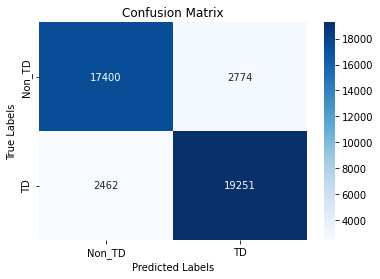

In [36]:
for fold in range(0, CONFIG['n_fold']):
    print(f"{y_}====== Fold: {fold} ======{sr_}")
    run = wandb.init(project='TD_Paper_results', 
                     config=CONFIG,
                     job_type='Train',
                     group=CONFIG['group'],
                     tags=[CONFIG['model_name'], f'{HASH_NAME}'],
                     name=f'{HASH_NAME}-fold-{fold}',
                     anonymous='must')
    
    # Create Dataloaders
    train_loader, valid_loader = prepare_loaders(fold=fold)
    
    model = TD_Model(CONFIG['model_name'])
    model.to(CONFIG['device'])
    
    # Define Optimizer and Scheduler
    optimizer = AdamW(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=CONFIG['weight_decay'])
    scheduler = fetch_scheduler(optimizer)
    
    model, history = run_training(model, optimizer, scheduler,
                                  device=CONFIG['device'],
                                  num_epochs=CONFIG['epochs'],
                                  fold=fold)
    
    run.finish()
    
    del model, history, train_loader, valid_loader
    _ = gc.collect()
    print()

<h2> Testing Inference </h2>


In [24]:
import warnings,transformers,logging,torch

warnings.simplefilter('ignore')
logging.disable(logging.WARNING)

In [25]:
test_df = test_vscode_df

In [26]:
test_df

,text,label
1062,see images below of the various different icon...,1
5143,\r\r\r\r\r\r\r\r\r report issue dialog can ass...,0
1230,related to the discussion in we need to find ...,1
152,we editorcontriboutlinemarker which i dont thi...,1
2090,when i investigated for i stumbled across \r\...,1
...,...,...
5047,follow up from \r\rin my testing the file watc...,0
4720,os all\razure resource extension build version...,0
173,since editorcursorblinking now has a bunch of ...,1
1244,testing \r\r\r\rnew format for the regions\r\r,1


In [27]:
class TD_TestDataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.text = df['text'].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
                        text,
                        truncation=True,
                        add_special_tokens=True,
                        max_length=self.max_len
                    )
        
        samples = {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask'],
            
        }

        if 'token_type_ids' in inputs:
            samples['token_type_ids'] = inputs['token_type_ids']
        
        return samples

In [28]:
collate_fn = DataCollatorWithPadding(tokenizer=CONFIG['tokenizer'])

softmax = nn.Softmax(dim=1)
model = TD_Model(CONFIG['model_name'])

In [29]:
def prepare_test_loader(test_df):    
    test_dataset = TD_TestDataset(test_df, 
                                   tokenizer=CONFIG['tokenizer'], 
                                   max_length=CONFIG['max_length'])
    
    test_loader = DataLoader(test_dataset, 
                             batch_size=CONFIG['valid_batch_size'], 
                             collate_fn=collate_fn, 
                             num_workers=2, 
                             shuffle=False, 
                             pin_memory=True, 
                             drop_last=False)
    return test_loader

test_loader = prepare_test_loader(test_df)

In [30]:
@torch.no_grad()
def inference(test_loader, model, device):
    preds = []
    preds_target = []
    model.eval()
    model.to(device)
    
    bar = tqdm(enumerate(test_loader), total=len(test_loader))
    
    for step, data in bar: 
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        
        output = model(ids, mask)
        y_preds = softmax(torch.tensor(output.to('cpu'))).numpy()
        pred_target = torch.argmax(output, dim=-1).flatten().tolist()
        
        preds.append(y_preds)
        preds_target.append(pred_target) 
    predictions = np.concatenate(preds)
    predictions_label = np.concatenate(preds_target)
    return predictions , predictions_label

In [31]:
# Change the HASH_NAME according to new generated hash for your run
HASH_NAME = "ekgx4wmexn91"


In [32]:
deberta_predictions = []
deberta_predictions_labels = []



for fold in range(0, CONFIG['n_fold']):
    print("Fold {}".format(fold))
    
    state = torch.load(f'{HASH_NAME}-Loss-Fold-{fold}.bin')
    model.load_state_dict(state)
    
    prediction, predictions_label = inference(test_loader, model, CONFIG['device'])
    deberta_predictions.append(prediction)
    deberta_predictions_labels.append(predictions_label)
    del state, prediction; gc.collect()
    torch.cuda.empty_cache()
del model

Fold 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 240/240 [00:55<00:00,  4.31it/s]


Fold 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 240/240 [01:51<00:00,  2.15it/s]


Fold 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 240/240 [02:00<00:00,  1.99it/s]


In [33]:
deberta_predictions


[array([[0.37889507, 0.62110496],
        [0.7452096 , 0.25479043],
        [0.24239194, 0.757608  ],
        ...,
        [0.50040567, 0.49959433],
        [0.70768267, 0.2923173 ],
        [0.9965609 , 0.00343911]], dtype=float32),
 array([[0.12386973, 0.8761302 ],
        [0.65547234, 0.3445276 ],
        [0.03110693, 0.96889305],
        ...,
        [0.5231995 , 0.47680047],
        [0.4777107 , 0.52228934],
        [0.99630016, 0.0036999 ]], dtype=float32),
 array([[0.07862172, 0.92137825],
        [0.8620106 , 0.13798943],
        [0.07257067, 0.92742926],
        ...,
        [0.33274826, 0.66725165],
        [0.5135043 , 0.48649564],
        [0.9824996 , 0.01750037]], dtype=float32)]

In [34]:
predictions = np.mean(deberta_predictions, axis=0)
predictions

array([[0.19379552, 0.8062045 ],
       [0.7542308 , 0.24576914],
       [0.11535651, 0.8846434 ],
       ...,
       [0.4521178 , 0.54788214],
       [0.5662992 , 0.43370077],
       [0.9917869 , 0.00821313]], dtype=float32)

In [35]:
len(predictions)

3826

In [36]:
predictions

array([[0.19379552, 0.8062045 ],
       [0.7542308 , 0.24576914],
       [0.11535651, 0.8846434 ],
       ...,
       [0.4521178 , 0.54788214],
       [0.5662992 , 0.43370077],
       [0.9917869 , 0.00821313]], dtype=float32)

In [37]:
test_df["prediction_0"] = predictions[:, 0] 

In [38]:
test_df["prediction_1"] = predictions[:, 1] 

In [39]:
for i in range(0, CONFIG['n_fold']):

    test_df[f"prediction_label_fold_{i}"] = deberta_predictions_labels[i]


In [40]:
test_df

,text,label,prediction_0,prediction_1,prediction_label_fold_0,prediction_label_fold_1,prediction_label_fold_2
1062,see images below of the various different icon...,1,0.193796,0.806204,1,1,1
5143,\r\r\r\r\r\r\r\r\r report issue dialog can ass...,0,0.754231,0.245769,0,0,0
1230,related to the discussion in we need to find ...,1,0.115357,0.884643,1,1,1
152,we editorcontriboutlinemarker which i dont thi...,1,0.190990,0.809010,1,1,1
2090,when i investigated for i stumbled across \r\...,1,0.112650,0.887350,1,1,1
...,...,...,...,...,...,...,...
5047,follow up from \r\rin my testing the file watc...,0,0.449758,0.550242,1,1,0
4720,os all\razure resource extension build version...,0,0.935809,0.064191,0,0,0
173,since editorcursorblinking now has a bunch of ...,1,0.452118,0.547882,0,0,1
1244,testing \r\r\r\rnew format for the regions\r\r,1,0.566299,0.433701,0,1,0


In [41]:
len(test_df)

3826

In [42]:
test_df['Max'] = test_df[['prediction_0','prediction_1']].idxmax(axis=1)

In [43]:
test_df["pred"] = test_df['Max'].apply(lambda x: x.replace("prediction_0", "0"))

In [44]:
test_df["pred"] = test_df['pred'].apply(lambda x: x.replace("prediction_1", "1"))


In [45]:
test_df["pred"] = test_df["pred"].astype(int)

In [46]:
test_df

,text,label,prediction_0,prediction_1,prediction_label_fold_0,prediction_label_fold_1,prediction_label_fold_2,Max,pred
1062,see images below of the various different icon...,1,0.193796,0.806204,1,1,1,prediction_1,1
5143,\r\r\r\r\r\r\r\r\r report issue dialog can ass...,0,0.754231,0.245769,0,0,0,prediction_0,0
1230,related to the discussion in we need to find ...,1,0.115357,0.884643,1,1,1,prediction_1,1
152,we editorcontriboutlinemarker which i dont thi...,1,0.190990,0.809010,1,1,1,prediction_1,1
2090,when i investigated for i stumbled across \r\...,1,0.112650,0.887350,1,1,1,prediction_1,1
...,...,...,...,...,...,...,...,...,...
5047,follow up from \r\rin my testing the file watc...,0,0.449758,0.550242,1,1,0,prediction_1,1
4720,os all\razure resource extension build version...,0,0.935809,0.064191,0,0,0,prediction_0,0
173,since editorcursorblinking now has a bunch of ...,1,0.452118,0.547882,0,0,1,prediction_1,1
1244,testing \r\r\r\rnew format for the regions\r\r,1,0.566299,0.433701,0,1,0,prediction_0,0


In [47]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(test_df["label"].values, test_df["pred"].values)

print(cf_matrix)

[[2035  279]
 [ 312 1200]]


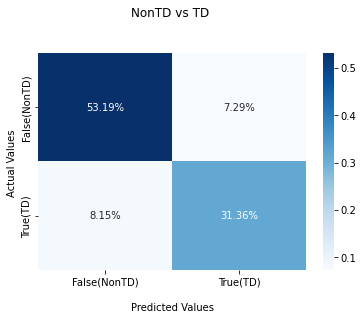

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('NonTD vs TD \n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False(NonTD)','True(TD)'])
ax.yaxis.set_ticklabels(['False(NonTD)','True(TD)'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [49]:
from sklearn.metrics import classification_report


print(classification_report(test_df["label"].values, test_df["pred"].values))

              precision    recall  f1-score   support

           0       0.87      0.88      0.87      2314
           1       0.81      0.79      0.80      1512

    accuracy                           0.85      3826
   macro avg       0.84      0.84      0.84      3826
weighted avg       0.85      0.85      0.85      3826



In [51]:
test_df[["text","label","pred"]].to_csv("VSCODE_70Test_inference.csv")